# Dynamische Generierung einer an das Regelwerk angepassten "openthesaurus.json"-Datei

In [44]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
openthesaurus_path = '../data/openthesaurus.txt'
regelwerk_path = '../data/regelbasierte_suche.json'
output_json_path = '../results/openthesaurus_processed.json'

# Regelwerk laden
with open(regelwerk_path, 'r', encoding='utf-8') as f:
    regelwerk = json.load(f)

# Merkmale und ihre positiven/negativen Attribute aus dem Regelwerk
merkmale = regelwerk["merkmale"]

# Wörterbuch zur Speicherung der Kategorien und ihrer Wörter mit Attributen
output_data = defaultdict(lambda: defaultdict(dict))

Zuordnung von Wörtern in die entsprechenden Merkmalskategorien

In [ ]:
# Extrahieren von Wörtern und Attributen aus einer Zeile
def parse_line(line):
    # Extrahiere Wörter und Attribute in Klammern
    parts = [part.strip() for part in line.split(';')]
    word_attributes = []

    for part in parts:
        # Suche nach Attributen in Klammern
        match = re.search(r'\((.*?)\)', part)
        if match:
            # Falls Attribute gefunden werden, speichere diese und entferne die Klammern
            attributes = [attr.strip() for attr in match.group(1).split(',')]
            word = re.sub(r'\(.*?\)', '', part).strip()
        else:
            word = part.strip()
            attributes = []

        word_attributes.append((word, attributes))
    
    return word_attributes

# Datei zeilenweise lesen und verarbeiten
with open(openthesaurus_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Ignoriere Kommentare und leere Zeilen
        if line.startswith('#') or not line.strip():
            continue
        
        # Hauptwörter und ihre spezifischen Attribute extrahieren
        word_attributes = parse_line(line)
        
        # Jedes Hauptwort und seine Attribute durchgehen und in die Struktur einfügen
        for word, attributes in word_attributes:
            is_main_word = bool(attributes)  # Hat das Hauptwort Attribute in Klammern?

            for category, rules in merkmale.items():
                positive_attributes = set(rules.get("positive", []))
                negative_attributes = set(rules.get("negative", []))

                # Initialisiere positive und negative Attribute für die Kategorie
                word_data = {
                    "positive": [],
                    "negative": [],
                    "synonyms": []
                }
                
                # Füge positive und negative Attribute gemäß Regelwerk hinzu
                for attr in attributes:
                    if attr in positive_attributes and attr not in word_data["positive"]:
                        word_data["positive"].append(attr)
                    elif attr in negative_attributes and attr not in word_data["negative"]:
                        word_data["negative"].append(attr)
                
                # Nur Wörter mit Attributen hinzufügen, sonst als Synonym behandeln
                if word_data["positive"] or word_data["negative"]:
                    output_data[category][word] = word_data
                else:
                    # Füge das Wort als Synonym zu anderen Wörtern derselben Zeile hinzu
                    for main_word, _ in word_attributes:
                        if main_word != word and main_word in output_data[category]:
                            output_data[category][main_word]["synonyms"].append(word)

# Ergebnis in JSON-Datei
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=4, ensure_ascii=False)

print("JSON-Datei erfolgreich generiert.")


JSON-Datei erfolgreich generiert.


# Sortierung von Sätzen anhand ihres Scorings für verschiedene Merkmale

Einlesen der Datensätze

In [ ]:
# Dateipfade
processed_json_path = '../results/openthesaurus_processed.json'
dataset_path = '../data/results.array.json'
regelwerk_path = '../data/regelbasierte_suche.json'
output_path = '../results/genre_based_scoring_results.json'
global_output_path = '../results/global_sentence_scoring_results.json'

# JSON-Dateien laden
with open(processed_json_path, 'r', encoding='utf-8') as f:
    processed_data = json.load(f)

with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

with open(regelwerk_path, 'r', encoding='utf-8') as f:
    regelwerk = json.load(f)

# Merkmale und ihre positiven/negativen Attribute aus dem Regelwerk
merkmale = regelwerk["merkmale"]

Funktion zum Scoring eines Satzes basierend auf einem Merkmal


In [15]:
def score_sentence(sentence, category, category_data):
    score = 0
    words = sentence.split()
    
    # Lade positive und negative Attribute des Merkmals
    positive_attributes = set(merkmale[category].get("positive", []))
    negative_attributes = set(merkmale[category].get("negative", []))
    
    for word in words:
        word_score = 0
        # Prüfen, ob das Wort in den Kategorie-Daten vorhanden ist
        word_data = category_data.get(word.lower())
        if word_data:
            # Positivpunkte für positive Attribute
            word_score += sum(1 for attr in word_data["positive"] if attr in positive_attributes)
            # Negativpunkte für negative Attribute
            word_score -= sum(1 for attr in word_data["negative"] if attr in negative_attributes)
        
        score += word_score
    return score

Vollständige Analyse aller Sätze innerhalb eines Genres
- (Top 5 stärkste und 2 schwächste Sätze pro Merkmal)

In [18]:
def full_scoring_analysis():
    results = defaultdict(lambda: defaultdict(list))

    for category, category_data in processed_data.items():
        for theme, sentences in dataset.items():
            category_scores = []
            
            for sentence in sentences:
                score = score_sentence(sentence, category, category_data)
                category_scores.append((sentence, score))
            
            # Sortieren der Sätze nach Score (absteigend)
            category_scores.sort(key=lambda x: x[1], reverse=True)
            
            # 5 stärkste und 2 schwächste Vertreter auswählen
            strongest_representatives = category_scores[:5]
            weakest_representatives = category_scores[-2:]
            
            # Ergebnisse nach Kategorie und Genre speichern
            results[category][theme] = {
                "strongest": strongest_representatives,
                "weakest": weakest_representatives
            }

    # Speichern der genre-basierten Ergebnisse
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    print("Genre-basierte Scoring-Analyse abgeschlossen und gespeichert.")
    
    # Rückgabe der Ergebnisse für die globale Analyse
    return results

# Aufruf und Speicherung der Ergebnisse
results = full_scoring_analysis()


Genre-basierte Scoring-Analyse abgeschlossen und gespeichert.


Vollständige Analyse aller Sätze über alle Genres hinweg
- (Top 5 stärkste und 2 schwächste Sätze pro Merkmal)

In [35]:
def global_scoring_analysis(results):
    # Dictionary, um Scores für jedes Merkmal über alle Genres hinweg zu speichern
    global_results = defaultdict(list)

    # Durchläuft die bereits berechneten Ergebnisse aus full_scoring_analysis
    for category, themes in results.items():
        for theme_data in themes.values():
            for sentence, score in theme_data["strongest"]:
                global_results[category].append((sentence, score))
            for sentence, score in theme_data["weakest"]:
                global_results[category].append((sentence, score))

    # Dictionary zur Speicherung der stärksten und schwächsten Sätze pro Merkmal
    final_global_results = {}

    for category, sentence_scores in global_results.items():
        # Sortieren nach Score (absteigend)
        sentence_scores.sort(key=lambda x: x[1], reverse=True)

        # Top 5 und Bottom 2 für jedes Merkmal auswählen
        strongest_representatives = sentence_scores[:5]
        weakest_representatives = sentence_scores[-2:]

        # Ergebnisse nach Kategorie (Merkmal) speichern
        final_global_results[category] = {
            "strongest": strongest_representatives,
            "weakest": weakest_representatives
        }

    # Speichern der globalen Ergebnisse
    with open(global_output_path, 'w', encoding='utf-8') as f:
        json.dump(final_global_results, f, indent=4, ensure_ascii=False)
    print("Globale Scoring-Analyse über alle Genres hinweg abgeschlossen und gespeichert.")

# Aufruf der globalen Scoring-Analyse mit den vollständigen Ergebnissen
global_scoring_analysis(results)


Globale Scoring-Analyse über alle Genres hinweg abgeschlossen und gespeichert.


Individuelle Analyse für eine bestimmte Kategorie mit eigens gewählten Sätzen

In [37]:
# Indviduelle Kategorisierung und Sortierung der Sätze
def custom_scoring_analysis(sentences, category):
    category_data = processed_data.get(category)
    if not category_data:
        print(f"Die Kategorie '{category}' existiert nicht in den Daten.")
        return []

    # Sätze scoren und sortieren
    scored_sentences = [(sentence, score_sentence(sentence, category, category_data)) for sentence in sentences]
    scored_sentences.sort(key=lambda x: x[1], reverse=True)
    return scored_sentences

# Sätze für die individuelle Analyse
example_sentences = [
    "Jedes Knarren der Dielen in dem alten Herrenhaus schien ein neues Grauen anzukündigen.",
    "In der Dunkelheit der alten Mine lauerte etwas Uraltes und Unheimliches auf ahnungslose Eindringlinge.",
    "Die alte Standuhr schlug zwölfmal, wobei jede Glocke mit einer unheilvollen Endgültigkeit erklang.",
    "Die seelenlosen Augen der alten Statuen schienen jede Bewegung zu verfolgen, ihr Blick war von unausgesprochenem Schrecken erfüllt.",
    "Dunkle Gestalten tauchten in der Peripherie des Blickfeldes auf und verschwanden, wenn man sie direkt ansah.",
    "Der dunkle, bedrohliche Nebel, der vom Meer heranzog, schien die Seelen der Verdammten mit sich zu tragen.",
    "Jede Nacht verschwanden die Bewohner der verfluchten Stadt in der Dunkelheit und kehrten nie wieder aus dem Abgrund zurück.",
    "In den Tiefen des alten Brunnens krallte sich etwas verzweifelt fest, um seinem dunklen Gefängnis zu entkommen.",
    "Der ranzige Gestank der Verwesung erfüllte den einst so schönen Garten, der nun von alptraumhaften, monströsen Pflanzen überwuchert war.",
    "Unter den Dielen waren beunruhigende Geräusche zu vernehmen, die auf etwas Lebendiges hindeuteten.",
    "Ich weinte voller Vorfreude auf die schicksalhafte Zukunft, welche mich mit warmen Armen und mit Liebe erfüllten Augen empfangen würde."
]

# Kategorie zur Analyse auswählen
category_to_analyze = "Plauderhaft"

# Sortierte Sätze für die angegebene Kategorie
sorted_sentences = custom_scoring_analysis(example_sentences, category_to_analyze)

# Ausgabe der sortierten Sätze
print("Sortierte Sätze für die Kategorie:", category_to_analyze)
for sentence, score in sorted_sentences:
    print(f"Score: {score} | Satz: {sentence}")


Sortierte Sätze für die Kategorie: Plauderhaft
Score: 6 | Satz: Der dunkle, bedrohliche Nebel, der vom Meer heranzog, schien die Seelen der Verdammten mit sich zu tragen.
Score: 4 | Satz: In der Dunkelheit der alten Mine lauerte etwas Uraltes und Unheimliches auf ahnungslose Eindringlinge.
Score: 4 | Satz: Der ranzige Gestank der Verwesung erfüllte den einst so schönen Garten, der nun von alptraumhaften, monströsen Pflanzen überwuchert war.
Score: 4 | Satz: Unter den Dielen waren beunruhigende Geräusche zu vernehmen, die auf etwas Lebendiges hindeuteten.
Score: 4 | Satz: Ich weinte voller Vorfreude auf die schicksalhafte Zukunft, welche mich mit warmen Armen und mit Liebe erfüllten Augen empfangen würde.
Score: 3 | Satz: Die alte Standuhr schlug zwölfmal, wobei jede Glocke mit einer unheilvollen Endgültigkeit erklang.
Score: 3 | Satz: Die seelenlosen Augen der alten Statuen schienen jede Bewegung zu verfolgen, ihr Blick war von unausgesprochenem Schrecken erfüllt.
Score: 3 | Satz: Jede

Visualisierung der individuellen Analyse

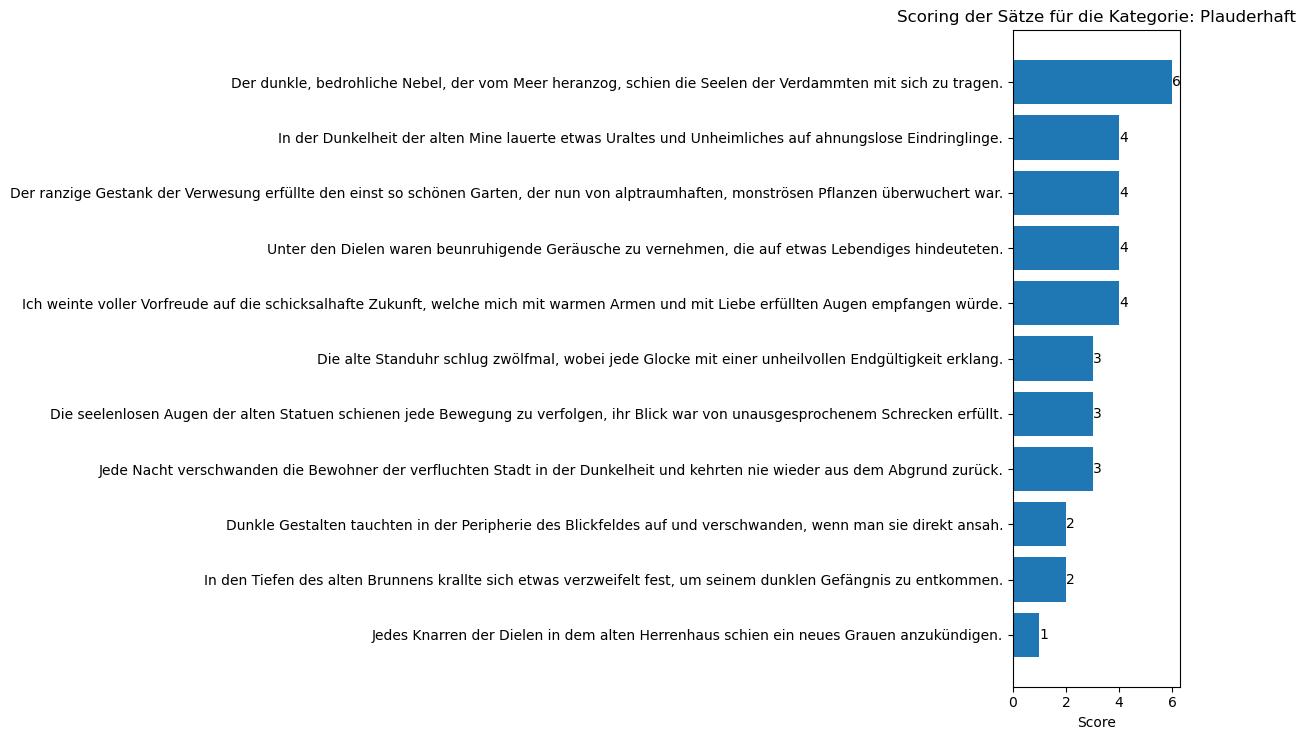

In [ ]:
def visualize_custom_scoring(sorted_sentences, category):
    # Extrahiere Sätze und ihre Scores
    sentences = [s[0] for s in sorted_sentences]
    scores = [s[1] for s in sorted_sentences]

    # Plot erstellen
    plt.figure(figsize=(12, min(2 + 0.5 * len(sentences), 10)))  # Dynamische Höhe je nach Satzanzahl
    bars = plt.barh(sentences, scores, align='center')
    plt.xlabel('Score')
    plt.title(f'Scoring der Sätze für die Kategorie: {category}')
    
    # Sortierung Stärkster bis schwächster Vertreter
    plt.gca().invert_yaxis()

    # Score-Werte auf die Balken schreiben
    for bar, score in zip(bars, scores):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score}', va='center', ha='left', fontsize=10)

    plt.tight_layout()
    plt.show()

# Analysiere / sortiere Beispiel-Sätze
sorted_sentences = custom_scoring_analysis(example_sentences, category_to_analyze)

# Visualisierung aufrufen
visualize_custom_scoring(sorted_sentences, category_to_analyze)


# Vektorisierung des Wortschatzes der Bücher mittels TF-IDF

Lade Bücherliste

In [ ]:
dataset_path = '../data/results.array.json'

with open(dataset_path, 'r', encoding='utf-8') as f:
    genres_data = json.load(f)

Datenvorbereitung

In [ ]:
# Sätze pro Genre zu einem Text zusammenfassen
genres_texts = {genre: " ".join(sentences) for genre, sentences in genres_data.items()}

# Genre-Namen und Textinhalte extrahieren
genre_names = list(genres_texts.keys())
genre_texts = list(genres_texts.values())

Vektorisierung

In [ ]:
# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(genre_texts)

# Cosinus-Ähnlichkeiten
cosine_similarities = cosine_similarity(tfidf_matrix)

# Ergebnis als DataFrame
cosine_df = pd.DataFrame(cosine_similarities, index=genre_names, columns=genre_names)
print("Cosinus-Ähnlichkeit zwischen den Genres:")
display(cosine_df)

Cosinus-Ähnlichkeit zwischen den Genres:


,nightmarish,positive,real-time,timely,uplifting,witty,whimsical,visionary,versatile,varied,...,authentic,assertive,analytical,amusing,agenda-driven,adventurous,advanced,addictive,action-packed,academic
nightmarish,1.000000,0.628234,0.688311,0.621456,0.535734,0.175694,0.568591,0.623105,0.698270,0.708903,...,0.717157,0.620010,0.579543,0.601785,0.610954,0.615434,0.641474,0.614623,0.652962,0.623401
positive,0.628234,1.000000,0.791062,0.628937,0.766768,0.204623,0.534849,0.732415,0.837628,0.797659,...,0.777609,0.814054,0.613656,0.588462,0.703692,0.594522,0.718401,0.826931,0.647258,0.677598
real-time,0.688311,0.791062,1.000000,0.903930,0.647125,0.195914,0.560058,0.860597,0.919134,0.893045,...,0.863919,0.857537,0.793529,0.680482,0.888973,0.713634,0.873574,0.761832,0.770411,0.851862
timely,0.621456,0.628937,0.903930,1.000000,0.528018,0.152086,0.507079,0.825523,0.811101,0.796035,...,0.775762,0.750348,0.775767,0.629484,0.851107,0.660763,0.841785,0.635236,0.711793,0.829553
uplifting,0.535734,0.766768,0.647125,0.528018,1.000000,0.255204,0.440663,0.608670,0.643573,0.626809,...,0.647834,0.647804,0.498422,0.486576,0.596529,0.545285,0.572287,0.804204,0.530251,0.539690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adventurous,0.615434,0.594522,0.713634,0.660763,0.545285,0.172147,0.574022,0.643600,0.732627,0.753391,...,0.753100,0.622616,0.616910,0.611746,0.655640,1.000000,0.678055,0.655267,0.685449,0.665468
advanced,0.641474,0.718401,0.873574,0.841785,0.572287,0.141409,0.532887,0.862057,0.881906,0.853588,...,0.815613,0.835519,0.824792,0.605462,0.829690,0.678055,1.000000,0.675540,0.741445,0.967399
addictive,0.614623,0.826931,0.761832,0.635236,0.804204,0.241178,0.531903,0.692597,0.776708,0.754555,...,0.758457,0.713225,0.596365,0.606194,0.689491,0.655267,0.675540,1.000000,0.628200,0.647742
action-packed,0.652962,0.647258,0.770411,0.711793,0.530251,0.156250,0.567624,0.687203,0.776815,0.788018,...,0.796770,0.683543,0.656290,0.620288,0.702347,0.685449,0.741445,0.628200,1.000000,0.718357


Visualisierung der Top 10 cosinus-ähnlichsten Genre-Paare

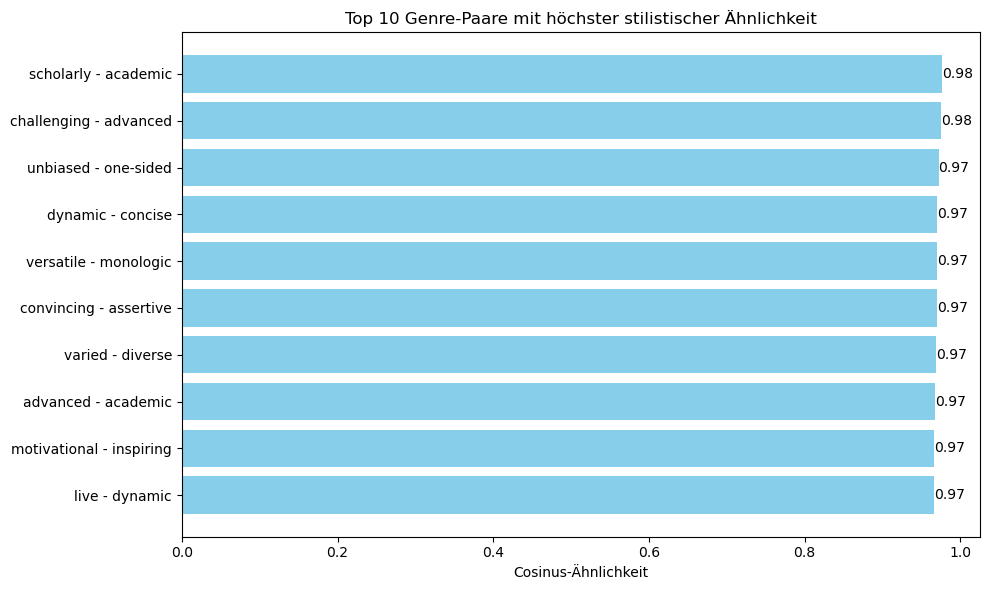

In [ ]:
# Extrahiere oberen Dreieckswerte der Cosinus-Ähnlichkeitsmatrix ohne Diagonaleinträge
similarities = []
for i in range(len(genre_names)):
    for j in range(i + 1, len(genre_names)):
        similarities.append((cosine_df.iloc[i, j], genre_names[i], genre_names[j]))

# Sortiere Ähnlichkeiten absteigend & wähle Top 10 Paare aus
top_10_similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:10]

# Paare und ihre Ähnlichkeiten extrahieren
top_10_scores = [pair[0] for pair in top_10_similarities]
top_10_pairs = [f"{pair[1]} - {pair[2]}" for pair in top_10_similarities]

# Visualisierung der Top 10 Paare mit der höchsten Ähnlichkeit
plt.figure(figsize=(10, 6))
bars = plt.barh(top_10_pairs, top_10_scores, color='skyblue')
plt.xlabel('Cosinus-Ähnlichkeit')
plt.title('Top 10 Genre-Paare mit höchster stilistischer Ähnlichkeit')
plt.gca().invert_yaxis()

# Score-Werte auf die Balken schreiben
for bar, score in zip(bars, top_10_scores):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{score:.2f}', va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()
